In [83]:
print(1)

1


In [6]:
import numpy as np
from math import isnan
import threading as trd
import math
import random as rnd
import copy
    

#def estimate_gaussian(data):
 #   return np.mean(data),np.cov(data)
    
    
def info_gain(data,cov,data_l,cov_l,data_r,cov_r):
    
    a=np.linalg.det(cov)
    if(isnan(a)==True):
        a=0.000000000000000000001
    a=np.log(abs(a))
    
    
    b=np.linalg.det(cov_l)
    if np.isnan(b)==True:
        b=0.000000000000000000001
    #print(data_l.shape[1])
    b=(data_l.shape[0]/data.shape[0]) * np.log(abs(b))
    
    
    c=np.linalg.det(cov_r)
    if np.isnan(c)==True:
        c=0.000000000000000000001
    c=(data_r.shape[0]/data.shape[0]) * np.log(abs(c))
    
    
    print('b: '+str(b) +' shape: '+str(data_l.shape))
    print('c: '+str(c) +' shape: '+str(data_r.shape))
    print('infogain: '+str(a-b-c))
    return a-b-c
    
def split_data(data,split,direction):
#    print('hi')
    left_data=np.array([[0,0]])
    right_data=np.array([[0,0]])
    for d in range(data.shape[0]):
        if data[d][direction]<=split:
            left_data=np.append(left_data,np.reshape(data[d],(1,data[d].shape[0])),axis=0)
        else:
            #print(1,left_data[d].shape[0])
            right_data=np.append(right_data,np.reshape(data[d],(1,data[d].shape[0])),axis=0)
            
   # print(left_data)
    left_data=np.delete(left_data,0,axis=0)
    right_data=np.delete(right_data,0,axis=0)
    return(left_data,right_data)
            

class RandomDensityTree:

    def __init__(self,max_depth=10,num_splits=10,min_infogain=1.5):
        self.max_depth = max_depth
        #self.root=data
        tree=[]
        for i in range(30):
            tree.append(0)
        self.tree=tree
        self.min_infogain=min_infogain
        self.num_splits=num_splits
        
    def fit(self,data):
        self.root=data
        self.mean = np.mean(data,axis=0)
        self.cov=np.cov(np.transpose(data))
        self.rootnode=Node(data,self.cov,[],self.tree,num_splits=self.num_splits,min_infogain=self.min_infogain,max_depth=self.max_depth,pointer=0)
        self.tree[0]=self.rootnode

    def predict(self,points):
        new=[]
        for p in points:
            new.append(self.rootnode.predict(p))
        new=np.array(new)
        return new
    
    def max_prob():
        leafs=self.leaf_nodes()
        probs=[]
        for l in leafs:
            probs.append(np.det(cov))*math.sqrt(2*math.pi)
        return max(probs)

    def get_means(self):
        means=[]
        self.rootnode.get_means(means)
        return means
    
    def get_split_info(self):
        histories=[]
        self.rootnode.get_split_info(means)
        return histories
   # def maxinfo(self):
    #    np.cov(np.transpose(left_data))
    def leaf_nodes(self):
        leafs=[]
        self.rootnode.leaf_nodes(leafs)
        return np.array(leafs)
    
class Node:
    
    def __init__(self,data,cov,history,tree,num_splits,min_infogain,max_depth,pointer):
        #self.min_infgain=min_infgain
        self.maxdepth=max_depth
        self.min_infogain=min_infogain
        self.pointer=pointer
        
        self.tree=tree
        self.num_splits=num_splits
    #    tree[pointer]={''}
        self.split=float('nan')
        self.split_dim=float('nan')
        self.history=copy.deepcopy(history)
        
        self.root=data
        self.mean=np.mean(data,axis=0)
        self.cov=cov
        self.isLeaf=False
        self.left_child=float('nan')
        self.right_child=float('nan')
        if(max_depth==0 or data.shape[1]==1):
            self.isLeaf=True
           
        else:
            
            rnd_splits=[]
            for dim in range(int(num_splits)):
                direction=rnd.choice([0,1])
                rnd_split=rnd.uniform(min(data[:,direction]),max(data[:,direction]))
                rnd_splits.append({'split':rnd_split,'direction':direction})

            left_datas=[]
            info_gains=np.zeros(num_splits)
            right_datas=[]

            covs_left=[]
            covs_right=[]

            for s in range(num_splits):#or the number of random splits
                
                left_data,right_data=split_data(data,rnd_splits[s]['split'],rnd_splits[s]['direction'])
                if(left_data.shape[0]>2 and right_data.shape[0]>2):
                    print('split ' +str(rnd_splits[s]['split'])+'  direction: '+str(rnd_splits[s]['direction']))
                   # left_data=[] #data left of the split
                   # right_data=[] #data right of the split
                    #for a in data:
                     #   if a <= splits[d]:
                      #      left_data.append(a)
                       # else:
                        #    right_data.append(a)
                    right_data

                    right_datas.append(right_data)
                    left_datas.append(left_data)

                    cov_l=np.cov(np.transpose(left_data))
                    cov_r=np.cov(np.transpose(right_data))

                    covs_left.append(cov_l)
                    covs_right.append(cov_r)
                 #   print(left_data)
                    info_gains[s]=(info_gain(data,self.cov,left_data,cov_l,right_data,cov_r)) #entropies of left and right data)
                else:
                    right_datas.append(float('nan'))
                    left_datas.append(float('nan'))
                    covs_left.append(float('nan'))
                    covs_right.append(float('nan'))
                    #information gain if this split is used
            if len(info_gains)==0:
                self.isLeaf=True
                   
            else:
         
                best=np.argmax(info_gains)
                print('best infogain: '+str(info_gains[best]))
                print(min_infogain)
                if info_gains[best] >= min_infogain:
             
                    self.split=rnd_splits[best]['split']   #best split
                    self.split_dim=rnd_splits[best]['direction'] 
                    print('history:'+str(history))
                    self.history.append(rnd_splits[best])
                    if(2*pointer+2>=len(tree)):
                        for i in range((2*pointer+2)-len(tree)+1):
                            tree.append(0)
                   # print(left_datas[best].shape)
                    #print(right_datas[best].shape)
                    #print((left_datas[best],covs_left[best],history,tree,self.num_splits,self.min_infogain,self.maxdepth-1,2*pointer+1))
                    self.history[len(self.history)-1]['child']='left'
                    leftnode=Node(left_datas[best],covs_left[best],self.history,tree,self.num_splits,self.min_infogain,self.maxdepth-1,2*pointer+1)
                    tree[2*pointer+1]=leftnode
                    self.left_child=leftnode
            
                   # print(len(right_datas[best],covs_right[best],history,self.num_splits,self.min_infogain,s2))
                    
                    self.history[len(self.history)-1]['child']='right'
                    rightnode=Node(right_datas[best],covs_right[best],self.history,tree,self.num_splits,self.min_infogain,self.maxdepth-1,2*pointer+2)
                    tree[2*pointer+2]=rightnode
                    self.right_child=rightnode
                    
                else:
         
                    self.isLeaf=True
        print((self.isLeaf,self.left_child))
    def predict(self,point):
        if self.isLeaf==True:
            return self.pointer
        else:
            if point[self.split_dim]>=self.split:
                return self.left_child.predict(point)
            else:
                return self.right_child.predict(point)
    '''         
     def get_split_info(self,histories):
        if(self.isLeaf==True):
            return self.history
            print('whoa')
        else:
            return [{'split':self.split,'split_dim':self.split_dim,},{'left_child':self.left_child.get_results()},{'right_child':self.right_child.get_results()}]
    '''
    def get_split_info(self,histories):
        if(self.isLeaf==True):
            histories.append(self.history)
        else:
            self.get_histories(histories)

    def get_means(self,means):
        if(self.isLeaf==True):
            means.append(self.mean)
        else:
            self.get_means(means)
            
    def maxprob():
        return 1
    
    def leaf_nodes(self,leafs):
      #  if self.left_child.isLeaf == True:
       #     leafs.append(self.left_child.pointer)
        if(self.isLeaf==True):
            leafs.append(self.pointer)
        else:
            self.left_child.leaf_nodes(leafs)
      #  if self.right_child.isLeaf == True:
       #     leafs.append(self.right_child)
        #else:
            self.right_child.leaf_nodes(leafs)
        
    def isnan(self):
        return False
    
def partition_function(tree, x):
    # generate a lot of samples in the bounds of the data and the size of the bounded shape
    samples, b_size = generate_monte_carlo_sample(x)
    # add gaussian probability dimension for those samples
    g_probs_samples = np.random.random(len(samples))*tree.max_prob
    b_size = b_size*tree.max_prob
    # predict the target leb af nodes for all samples
    leaf_node_ids = tree.predict(samples)
    # compute the distribution integral over each leaf node
    g_ints = np.zeros((len(tree.leaf_nodes),))
    for ln_id in range(len(tree.leaf_nodes)):
        leaf_node = tree.leaf_nodes[ln_id]
        mean_vec = leaf_node.mean
        cov_mat = leaf_node.cov
        mnd = stats.multivariate_normal(mean_vec, cov_mat)
        sample_id_mask = leaf_node_ids==ln_id
        g_probs = mnd(samples[sample_id_mask])
        g_cnt = np.sum(g_probs_samples<=g_probs)
        g_ints[ln_id] = g_cnt/len(samples)*b_size
    


def generate_monte_carlo_sample(X, num_samples=1000000):
    """
    Generate more sample points
    """
    samples = np.random.rand(num_sample,len(x[0]))
    d_mins = np.min(X,axis=0)
    d_maxs = np.max(X,axis=0)
    samples = np.add(np.multiply(samples,d_maxs-d_mins),d_mins)
    b_size = np.prod(d_maxs-d_mins)
    return samples, b_size    
'''
class RandomDensityForest:
    def _init(self,max_length=10,num_trees=10):
        self.max_length=max_length
        self.num_trees=num_trees
        
    def train_and_stuff(data):
        #lauch DensityTrees
        #train on data
        #return results
        #use partition function
        #combine them into final result
    
    I= entropy - sum
theta= max(I)    
'''

'\nclass RandomDensityForest:\n    def _init(self,max_length=10,num_trees=10):\n        self.max_length=max_length\n        self.num_trees=num_trees\n        \n    def train_and_stuff(data):\n        #lauch DensityTrees\n        #train on data\n        #return results\n        #use partition function\n        #combine them into final result\n    \n    I= entropy - sum\ntheta= max(I)    \n'

In [11]:
import numpy as np
print(DensityTree.leaf_nodes())

[ 3  4 11 12  6]


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

data = np.zeros([100,2])
for i in range(30):
    data[i]=np.random.normal([2,2],0.5)
   # data[i][0]=np.random.normal(2,0.5)[0]
    #data[i][1]=np.random.normal(2)[1]
for i in range(30):
    data[30+i]=np.random.normal([5,5],0.5)
    #data[30+i][1]=np.random.normal(5,0.5) 
for i in range(30):
    data[60+i]=np.random.normal([5,1],0.5)
   
for i in range(10):
    data[90+i]=np.random.normal([1,5],0.5)


DensityTree=RandomDensityTree()
DensityTree.fit(data)

split 2.45251755193  direction: 0
b: -0.37542169192 shape: (36, 2)
c: 0.487567221221 shape: (64, 2)
infogain: 2.21945010559
split 1.69795792186  direction: 1
b: -0.468782588738 shape: (34, 2)
c: 1.16178333561 shape: (66, 2)
infogain: 1.63859488802
split 1.77177431182  direction: 0
b: -0.27199889099 shape: (22, 2)
c: 1.29351272489 shape: (78, 2)
infogain: 1.31008180099
split 4.67341972876  direction: 0
b: 0.644444764962 shape: (51, 2)
c: -0.426435841875 shape: (49, 2)
infogain: 2.1135867118
split 1.17627238913  direction: 1
b: -0.669711634703 shape: (23, 2)
c: 1.60551572746 shape: (77, 2)
infogain: 1.39579154213
split 4.09607437135  direction: 1
b: -0.0391922561476 shape: (61, 2)
c: -0.00336199271244 shape: (39, 2)
infogain: 2.37414988375
split 2.09591008988  direction: 0
b: -0.383213190288 shape: (32, 2)
c: 0.794270290672 shape: (68, 2)
infogain: 1.9205385345
split 2.02323863605  direction: 1
b: -0.363233053604 shape: (45, 2)
c: 0.815624263912 shape: (55, 2)
infogain: 1.87920442458
bes

In [8]:

DensityTree2=RandomDensityTree()
DensityTree2.fit(data)
DensityTree2.predict([[2,3],[4,5]])

split 2.59758468887  direction: 0
b: -0.353740783633 shape: (38, 2)
c: 0.260069235833 shape: (62, 2)
infogain: 2.42526718269
split 2.95738658494  direction: 1
b: -0.176880180788 shape: (59, 2)
c: 0.131462133743 shape: (41, 2)
infogain: 2.37701368193
split 4.21367080847  direction: 1
b: 0.557054844641 shape: (66, 2)
c: -0.129052891303 shape: (34, 2)
infogain: 1.90359368155
split 5.64706118291  direction: 0
b: 2.21570804193 shape: (96, 2)
c: -0.188979401427 shape: (4, 2)
infogain: 0.304866994386
split 1.07998460525  direction: 0
b: -0.12129605216 shape: (7, 2)
c: 1.91378103813 shape: (93, 2)
infogain: 0.539110648916
split 4.59900199721  direction: 1
b: 0.822749559863 shape: (69, 2)
c: -0.143294441326 shape: (31, 2)
infogain: 1.65214051635
split 4.14958596363  direction: 0
b: 0.0813319478581 shape: (43, 2)
c: -0.250957050069 shape: (57, 2)
infogain: 2.5012207371
best infogain: 2.5012207371
1.5
history:[]
split 2.24866163684  direction: 1
b: -1.34009369413 shape: (22, 2)
c: 0.0577880591326

array([5, 5])

In [24]:
print(DensityTree.get_results())

AttributeError: 'RandomDensityTree' object has no attribute 'get_results'

[{'child': 'left', 'direction': 0, 'split': 3.4611913424559244}, {'child': 'left', 'direction': 1, 'split': 2.2392637110032361}]
(22, 2)
[{'child': 'left', 'direction': 0, 'split': 3.4611913424559244}, {'child': 'right', 'direction': 1, 'split': 2.2392637110032361}, {'child': 'left', 'direction': 1, 'split': 3.3000801823937387}, {'child': 'left', 'direction': 1, 'split': 2.6017827096744832}]
(5, 2)
[{'child': 'left', 'direction': 0, 'split': 3.4611913424559244}, {'child': 'right', 'direction': 1, 'split': 2.2392637110032361}, {'child': 'left', 'direction': 1, 'split': 3.3000801823937387}, {'child': 'right', 'direction': 1, 'split': 2.6017827096744832}]
(3, 2)
[{'child': 'left', 'direction': 0, 'split': 3.4611913424559244}, {'child': 'right', 'direction': 1, 'split': 2.2392637110032361}, {'child': 'right', 'direction': 1, 'split': 3.3000801823937387}]
(10, 2)
[{'child': 'right', 'direction': 0, 'split': 3.4611913424559244}, {'child': 'left', 'direction': 1, 'split': 4.3153900996135484}]

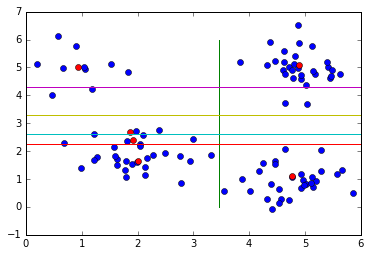

In [7]:
nodes=DensityTree.leaf_nodes()
plt.plot(data[:,0],data[:,1], "o")
for d in nodes:
    print(d.history)
    print(d.root.shape)
    plt.plot(d.mean[0],d.mean[1],'o',color='r')
 #   lines=d.history
  #  if lines['direction']==0:
   #     plot
   # plt.savefig('results')
plt.plot([3.4611913424559244,3.4611913424559244],[0,6])
#plt.plot([0,6],[ 4.0724581571601854, 4.0724581571601854])
plt.plot([0,6],[ 2.2392637110032361, 2.2392637110032361])
plt.plot([0,6],[ 2.6017827096744832,  2.6017827096744832])

plt.plot([0,6],[4.3153900996135484,  4.3153900996135484])

plt.plot([0,6],[ 3.3000801823937387, 3.3000801823937387])

#plt.plot( 0.86719180226239123, 'direction': 0)
#plt.plot([2.0024517583718917,2.0024517583718917],[-1,6])
#plt.plot([0.9883004157571309,0.9883004157571309],[-1,6])


#plt.plot( 4.64157772,  0.63988413,"o")
#plt.plot( 3.03334449,  2.46542821,"o")
#plt.plot( 4.24936537,  5.14213751,"o")
#plt.plot( 3.23164995,  5.9834305 ,"o")

[{'split': 3.245427000841719, 'direction': 1, 'child': 'left'}, {'split': 1.1241675743225339, 'direction': 1, 'child': 'left'}]
(23, 2)
[{'split': 3.245427000841719, 'direction': 1, 'child': 'left'}, {'split': 1.1241675743225339, 'direction': 1, 'child': 'right'}]
(37, 2)
[{'split': 3.245427000841719, 'direction': 1, 'child': 'right'}, {'split': 5.3848845245890073, 'direction': 1, 'child': 'left'}, {'split': 0.86719180226239123, 'direction': 0, 'child': 'left'}]
(3, 2)
[{'split': 3.245427000841719, 'direction': 1, 'child': 'right'}, {'split': 5.3848845245890073, 'direction': 1, 'child': 'left'}, {'split': 0.86719180226239123, 'direction': 0, 'child': 'right'}, {'split': 5.7306771060727044, 'direction': 1, 'child': 'left'}]
(3, 2)
[{'split': 3.245427000841719, 'direction': 1, 'child': 'right'}, {'split': 5.3848845245890073, 'direction': 1, 'child': 'left'}, {'split': 0.86719180226239123, 'direction': 0, 'child': 'right'}, {'split': 5.7306771060727044, 'direction': 1, 'child': 'right'}]


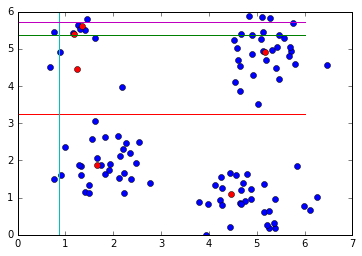

In [194]:
nodes=DensityTree.leaf_nodes()
plt.plot(data[:,0],data[:,1], "o")
for d in nodes:
    print(d.history)
    print(d.root.shape)
    plt.plot(d.mean[0],d.mean[1],'o',color='r')
    lines=d.history
    if lines['direction']==0:
        plot
    plt.savefig('results')
plt.plot([0,6],[5.358583094356550,5.358583094356550])
#plt.plot([0,6],[ 4.0724581571601854, 4.0724581571601854])
plt.plot([0,6],[  3.245427000841719,  3.245427000841719])
plt.plot([  0.86719180226239123,  0.86719180226239123],[0,6])
plt.plot([0,6],[ 5.7306771060727044,  5.7306771060727044])
#plt.plot( 0.86719180226239123, 'direction': 0)
#plt.plot([2.0024517583718917,2.0024517583718917],[-1,6])
#plt.plot([0.9883004157571309,0.9883004157571309],[-1,6])


#plt.plot( 4.64157772,  0.63988413,"o")
#plt.plot( 3.03334449,  2.46542821,"o")
#plt.plot( 4.24936537,  5.14213751,"o")
#plt.plot( 3.23164995,  5.9834305 ,"o")

In [181]:
data2 = np.zeros([100,2])
for i in range(100):
    data2[i]=np.random.normal([2,2],1)
    
print(np.linalg.det(np.cov(np.transpose(data2))))

0.986957740915


In [19]:
print(np.log(-1))

nan


c:\program files\python35\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
